## Compute Cross-correlation of Detected Calls from The Four-channel Microphone
- First, band-pass-filter the signals from the four-channel microphone
- Secondly, use detected call locations from `Aditya's detection` to segment the calls with given windows with lower and upper bounds `t_lb, t_ub`
- Compute the cross-correlation of call signals from receiver(microphone)-1-3, with respect to the receiver-4's call signal.

### Import Recordings from .wav file and Plot Recordings

In [1]:
# import numpy
import numpy as np

# import scipy
import scipy
from scipy import signal
from scipy.io import wavfile

# import matplotlib
import matplotlib.pyplot as plt

# import csv
import csv

# import pandas
import pandas as pd

In [2]:
# import .wav file
filename_wav='UBNA_23-09-15-19_49_24_16.wav'
Fs, data = wavfile.read(filename_wav) 
data=data/2**15 # divde data by 2^15, which has a data type of int16
data=data.astype(np.float32) # convert the data type to float32

<function matplotlib.pyplot.show(close=None, block=None)>

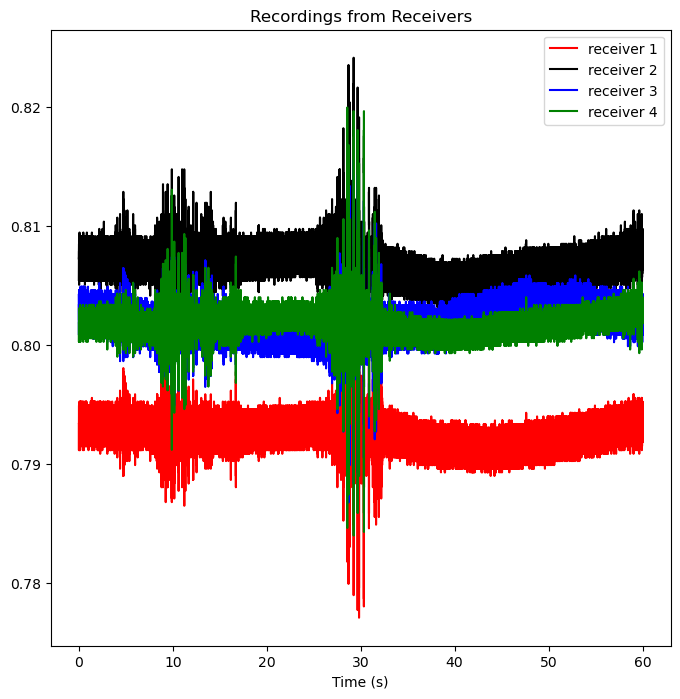

In [4]:
# plot recordings from .wav file
t=np.linspace(0,60-1/Fs,data.shape[0])
fig = plt.figure(figsize=(8, 8))
ax=fig.add_subplot()
plt.plot(t,data[:,0],color='r',label='receiver 1')
plt.plot(t,data[:,1],color='k',label='receiver 2')
plt.plot(t,data[:,2],color='b',label='receiver 3')
plt.plot(t,data[:,3],color='g',label='receiver 4')
ax.set_xlabel('Time (s)');ax.set_title('Recordings from Receivers')
ax.legend()
#ax.set_xlim(51,53);
plt.show

### Filtering and Plotting of the Recordings Using Band-pass Filter

<function matplotlib.pyplot.show(close=None, block=None)>

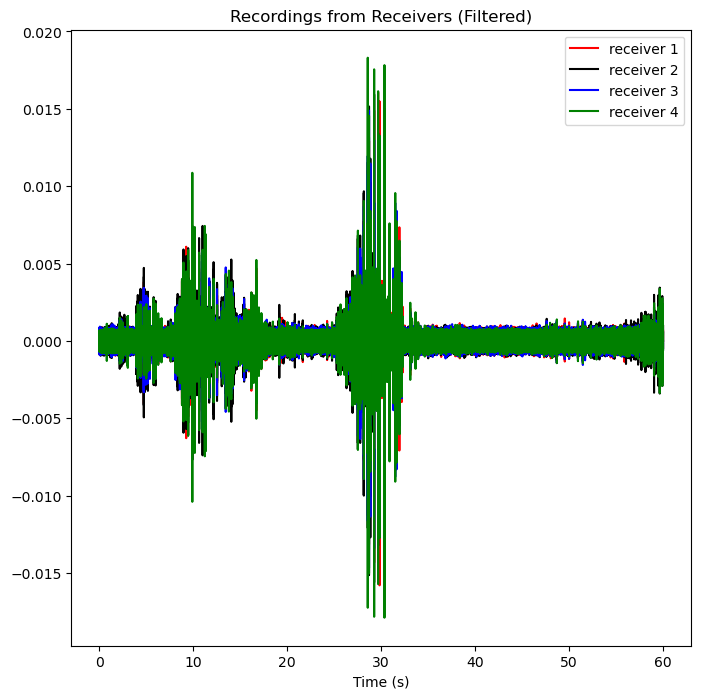

In [6]:
# bandpass filter the recordings
b,a=signal.butter(8,[10*1e3,60*1e3],btype='bandpass',fs=200*1e3)
data_filt=signal.filtfilt(b,a,data,axis=0)

fig = plt.figure(figsize=(8, 8))
ax=fig.add_subplot()
plt.plot(t,data_filt[:,0],color='r',label='receiver 1')
plt.plot(t,data_filt[:,1],color='k',label='receiver 2')
plt.plot(t,data_filt[:,2],color='b',label='receiver 3')
plt.plot(t,data_filt[:,3],color='g',label='receiver 4')
ax.set_xlabel('Time (s)'); ax.set_title('Recordings from Receivers (Filtered)')
#ax.set_xlim(51,53);
ax.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 800x800 with 0 Axes>

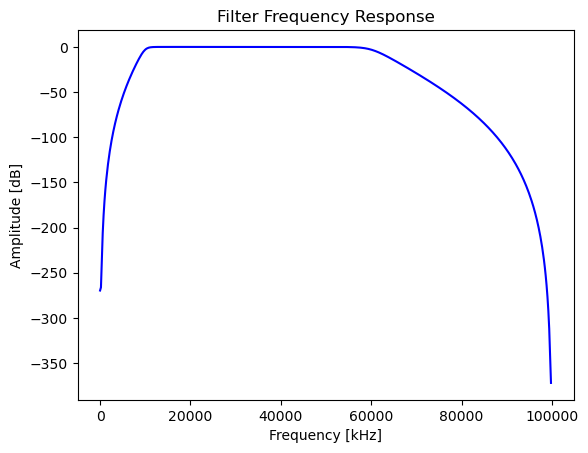

In [7]:
# get impulse response of the band-pass filter
f, h = signal.freqz(b,a,fs=Fs)

# plot the response of the filter
fig = plt.figure(figsize=(8, 8))
fig, ax1 = plt.subplots()
ax1.set_title('Filter Frequency Response')
ax1.plot(f, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]')
ax1.set_xlabel('Frequency [kHz]')
plt.show

### Segment Calls Using Detected Call Locations

In [9]:
# read start time of detected calls
filename_csv='C:/Users/YeonJoon Cheong/myrepos/ubna-bat-array/bd2_detections/UBNA_202309/20230915_central_pond/channel_4/batdetect2_pipeline_UBNA_23-09-15-19_49_24_16.csv'
call_data = pd.read_csv(filename_csv)
df = pd.DataFrame(call_data, columns=['start_time'])
#print(df)

# dataFrame to array
t_call=df.to_numpy();


<function matplotlib.pyplot.show(close=None, block=None)>

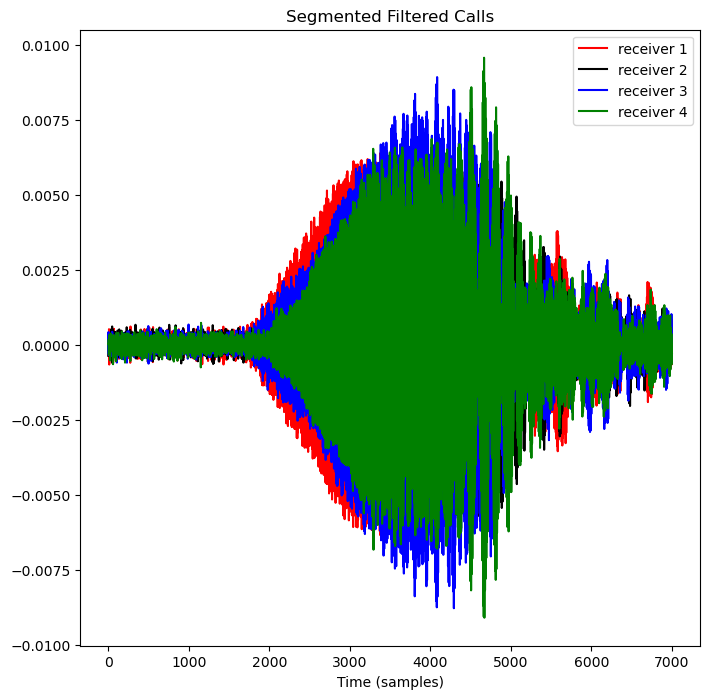

In [10]:
# segment calls within a defined window
N=220;
t_lb=10e-3;t_ub=25*1e-3 # lower and upper bound of time window
call0=data[int(t_call[N,0]*Fs-t_lb*Fs):int(t_call[N,0]*Fs+(t_ub*Fs)+1),:] # segemnted calls with unfiltered signals
call=data_filt[int(t_call[N,0]*Fs-t_lb*Fs):int(t_call[N,0]*Fs+(t_ub*Fs)+1),:] # segmented calls with filtered signals

fig = plt.figure(figsize=(8, 8))
ax=fig.add_subplot()
plt.plot(call[:,0],color='r',label='receiver 1')
plt.plot(call[:,1],color='k',label='receiver 2')
plt.plot(call[:,2],color='b',label='receiver 3')
plt.plot(call[:,3],color='g',label='receiver 4')
ax.set_xlabel('Time (samples)'); ax.set_title('Segmented Filtered Calls');ax.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

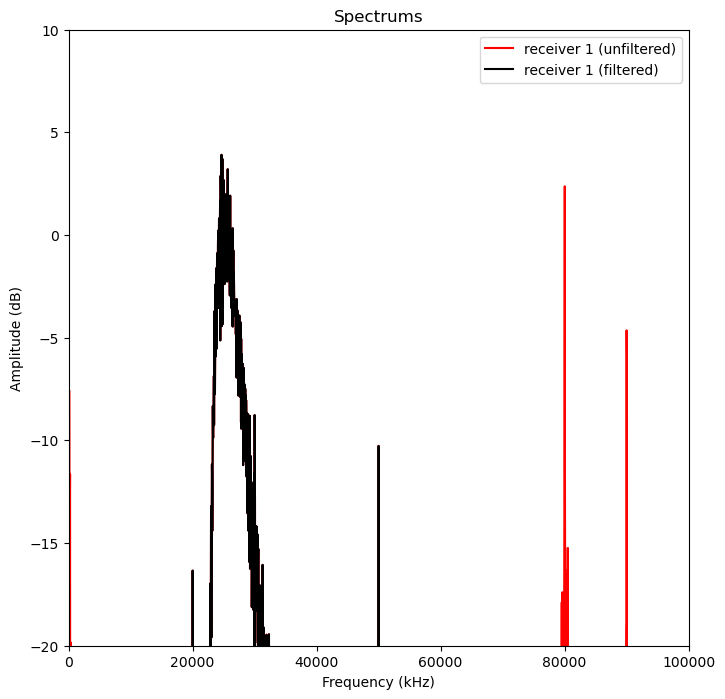

In [13]:
# compute spectrums of filtered/ulfiltered segmented calls to sanity-check calls

xf=scipy.fft.fftfreq(len(call),1/Fs)[:len(call//2)] # frequency contents of fft
call0f=scipy.fft.fft(call0,axis=0)[:len(call//2)] # fft unfiltered calls
callf=scipy.fft.fft(call,axis=0)[:len(call//2)]  # fft filtered calls

# plot spectrums
fig = plt.figure(figsize=(8, 8))
ax=fig.add_subplot()
plt.plot(xf,20*np.log10(abs(call0f[:,0])),color='r',label='receiver 1 (unfiltered)')
plt.plot(xf,20*np.log10(abs(callf[:,0])),color='k',label='receiver 1 (filtered)')
ax.set_xlabel('Frequency (kHz)'); ax.set_ylabel('Amplitude (dB)'); 
ax.set_title('Spectrums');ax.legend(); ax.set_xlim(0*1e3,100*1e3);ax.set_ylim(-20,10);
plt.show

### Compute Cross-correlation and Plot Cross-correlation with Lags

In [14]:
# cross-correlation
corr1 = signal.correlate(call[:,3], call[:,0]) # cross-correlation of receiver 1 with receiver 4 recording
corr2 = signal.correlate(call[:,3], call[:,1]) # cross-correlation of receiver 2 with receiver 4 recording
corr3 = signal.correlate(call[:,3], call[:,2]) # cross-correlation of receiver 3 with receiver 4 recording
lags = signal.correlation_lags(len(call), len(call))

# normalize cross-correlation
corr1 /= np.max(corr1)
corr2 /= np.max(corr2)
corr3 /= np.max(corr3)

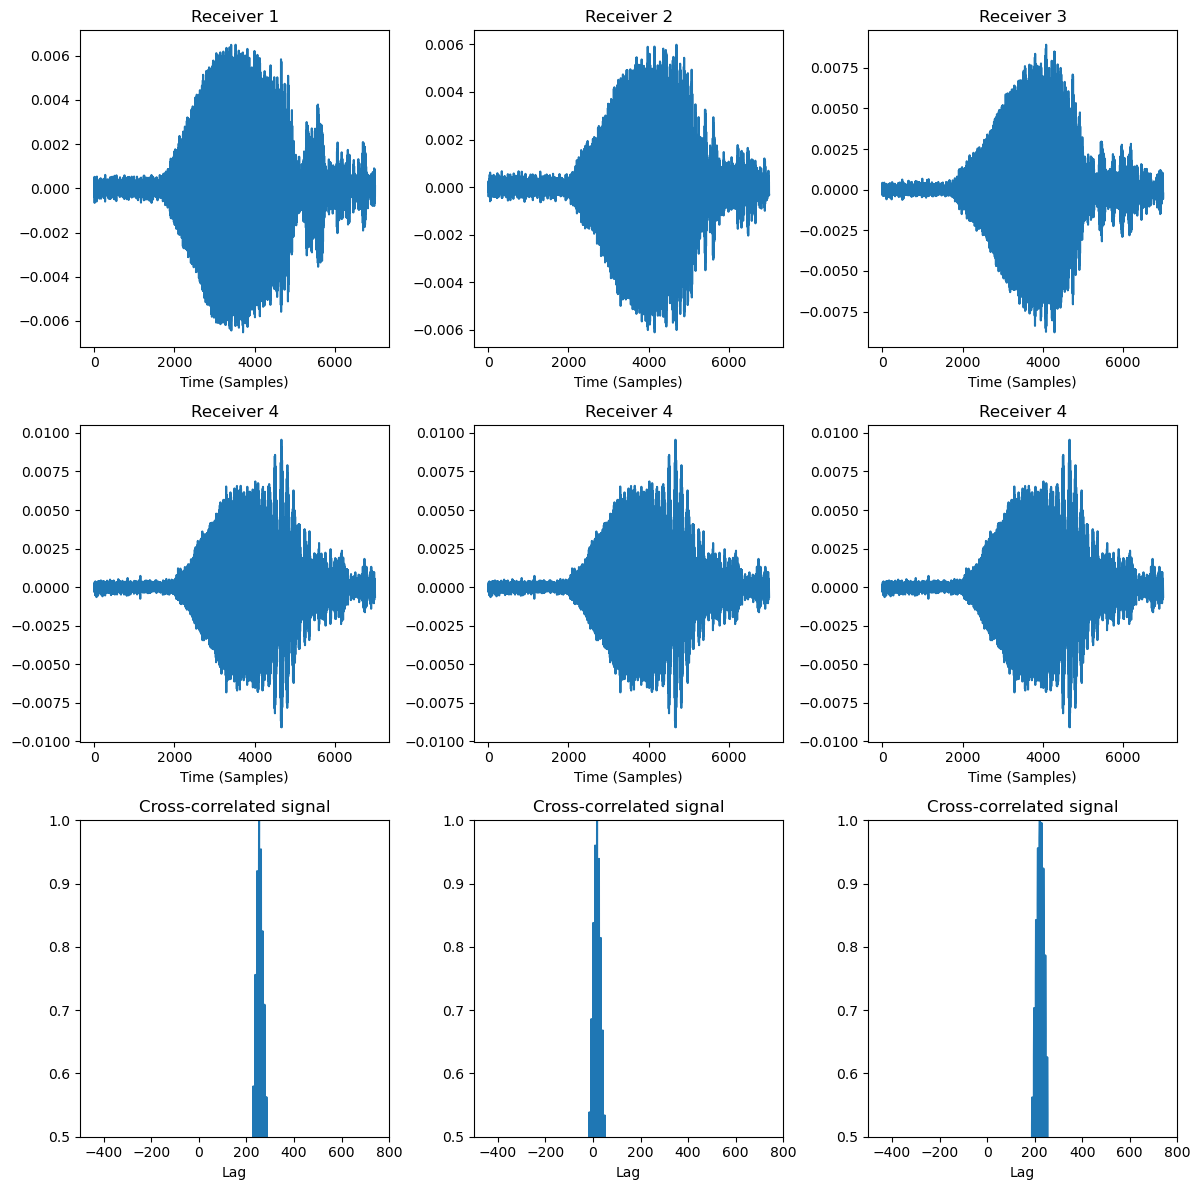

In [15]:
# plot cross-correlation delay and signals
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs[0,0].plot(call[:,0])
axs[0,0].set_title('Receiver 1');axs[0,0].set_xlabel('Time (Samples)')

axs[0,1].plot(call[:,1])
axs[0,1].set_title('Receiver 2');axs[0,1].set_xlabel('Time (Samples)')

axs[0,2].plot(call[:,2])
axs[0,2].set_title('Receiver 3');axs[0,2].set_xlabel('Time (Samples)')

axs[1,0].plot(call[:,3])
axs[1,0].set_title('Receiver 4');axs[1,0].set_xlabel('Time (Samples)')

axs[1,1].plot(call[:,3])
axs[1,1].set_title('Receiver 4');axs[1,1].set_xlabel('Time (Samples)')

axs[1,2].plot(call[:,3])
axs[1,2].set_title('Receiver 4');axs[1,2].set_xlabel('Time (Samples)')

axs[2,0].plot(lags,corr1)
axs[2,0].set_title('Cross-correlated signal');axs[2,0].set_xlabel('Lag')
axs[2,0].set_xlim(-500,800);axs[2,0].set_ylim(0.5,1)

axs[2,1].plot(lags,corr2)
axs[2,1].set_title('Cross-correlated signal');axs[2,1].set_xlabel('Lag')
axs[2,1].set_xlim(-500,800);axs[2,1].set_ylim(0.5,1)

axs[2,2].plot(lags,corr3)
axs[2,2].set_title('Cross-correlated signal');axs[2,2].set_xlabel('Lag')
axs[2,2].set_xlim(-500,800);axs[2,2].set_ylim(0.5,1)

fig.tight_layout()
plt.show()

In [16]:
# time-delay between receiver 1-3 and receiver 4 (maximum cross-correlation lag)
t14=(np.argmax(corr1)-len(call))/Fs
t24=(np.argmax(corr2)-len(call))/Fs
t34=(np.argmax(corr3)-len(call))/Fs

print('time delays are t14=',t14*1e3,'[ms] t24=',t24*1e3,'[ms] t34=',t34*1e3,'[ms]')

time delays are t14= 1.26 [ms] t24= 0.08 [ms] t34= 1.105 [ms]
